# Deep Learning: Image Classification

**Dataset and Goal**

This classification is done using the Viziometrics dataset. To learn more, please read the following papers: [paper1](https://ieeexplore.ieee.org/abstract/document/7888968), [paper2](https://arxiv.org/abs/1908.07465). This dataset contains 2k+ images from scientific publications that are hand-labeled as one of the five classes: equation, photo, scheme, table, and visualization. The train, validation, and test set has already been split. The goal of this model is to train neural network classifiers to predict the five labels.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from tensorflow import keras
from keras.preprocessing import image_dataset_from_directory # image.ImageDataGenerator is depreciated
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
# create train, validation, and test generators from our image directory

train_dataset = image_dataset_from_directory(
    directory=r'./viziometrics/train/',
    image_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    label_mode='categorical',
    shuffle=False,
    seed=42
)

val_dataset = image_dataset_from_directory(
    directory=r"./viziometrics/val/",
    image_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    label_mode='categorical',
    shuffle=False,
    seed=42
)

test_dataset = image_dataset_from_directory(
    directory=r"./viziometrics/test/",
    image_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    label_mode='categorical',
    shuffle=False,
    seed=42
)

Found 2733 files belonging to 5 classes.
Found 1523 files belonging to 5 classes.
Found 1563 files belonging to 5 classes.


## EDA

Sample images to get a better sense of classification targets.

In [4]:
class_images = {class_name: [] for class_name in test_dataset.class_names}

for images, labels in test_dataset:
    for i in range(images.shape[0]):
        # get class name
        class_index = labels[i].numpy().argmax()
        class_name = test_dataset.class_names[class_index]

        # store images by class
        class_images[class_name].append(images[i].numpy().astype("uint8"))

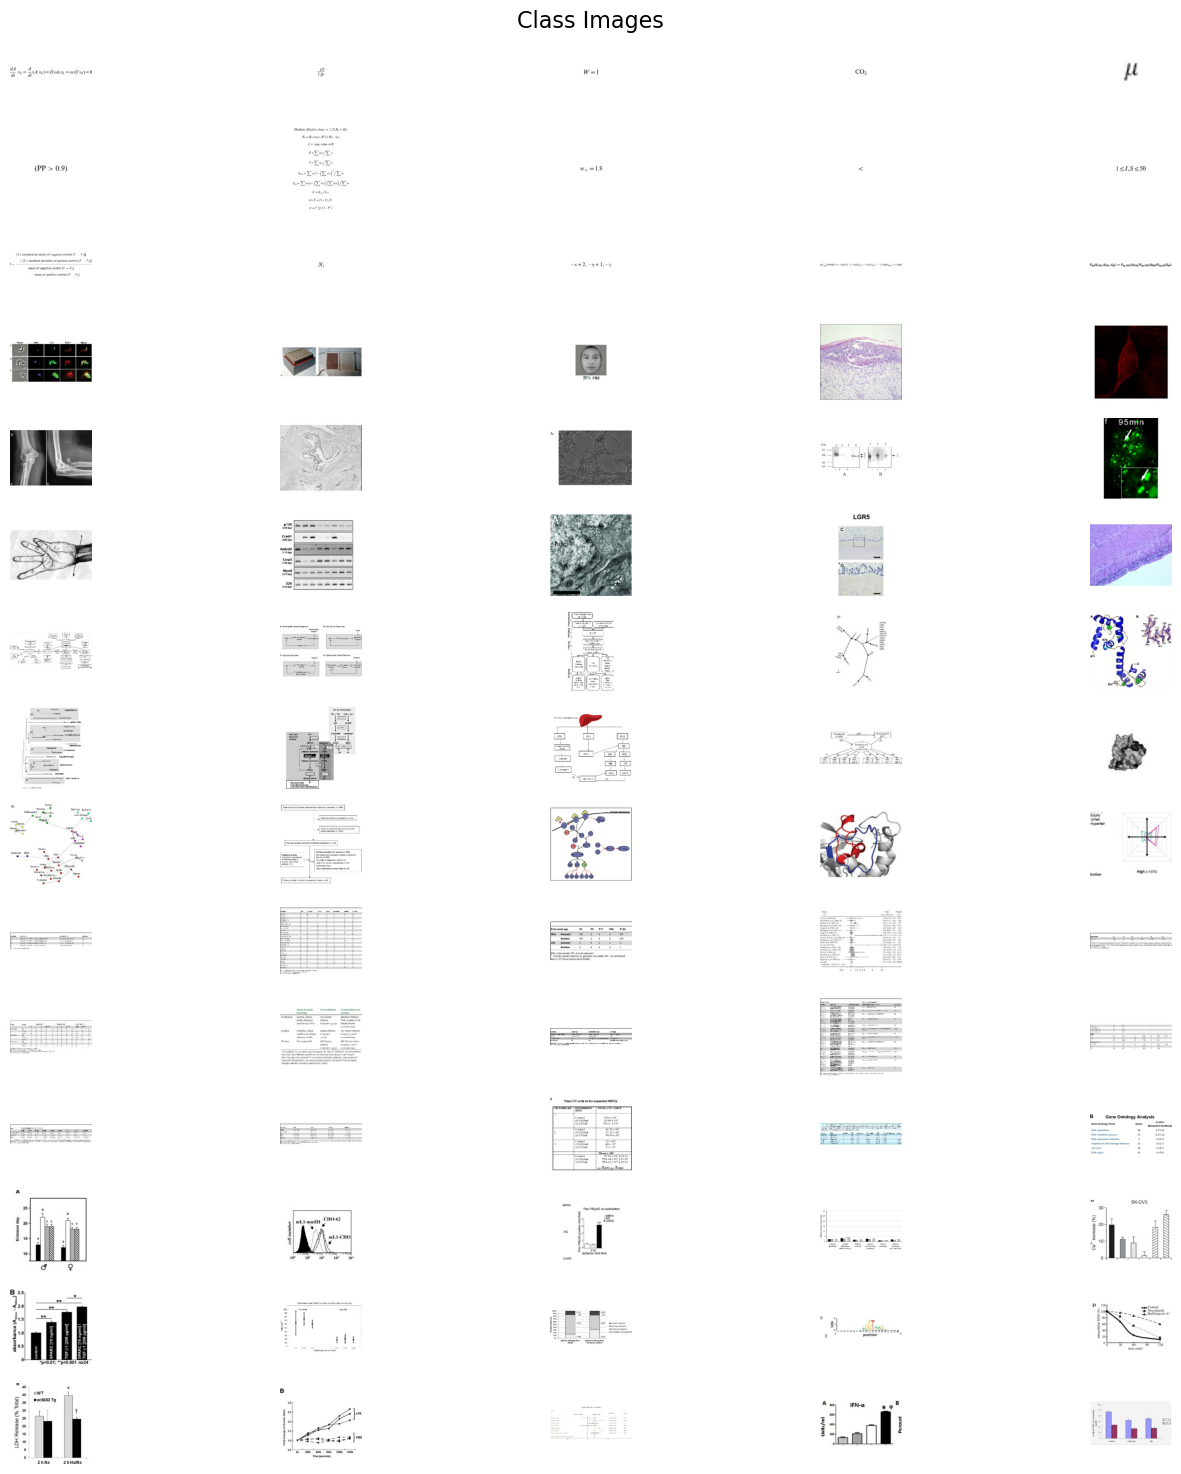

In [5]:
fig, axes = plt.subplots(3 * 5, 5, figsize=(15, 15))
fig.suptitle("Class Images", fontsize=16)

for class_idx, (class_name, images) in enumerate(class_images.items()):
    for row in range(3):
        selected_images = random.sample(images, 5)
        
        for col in range(5):
            ax = axes[class_idx * 3 + row, col]
            ax.imshow(selected_images[col])
            ax.axis("off")
            if col == 0:
                ax.set_ylabel(class_name, fontsize=12)

plt.tight_layout()
plt.show()

## Feature Extraction

This model will use a pretrained network (ResNet50) to extract features from the images. The last layer of ResNet50 is responsible for assigning a class label to each image. This model will be focusing on the avg_pooling layer initialized before final predictions.

In [6]:
# download the pre-trained ResNet50 model
resnet = keras.applications.resnet.ResNet50(weights='imagenet', input_shape=(224,224,3))

# inspect the ResNet50 architecture
resnet.summary()


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [7]:
layer_name = 'avg_pool'
resnet_embedder = Model(inputs=resnet.input,outputs=resnet.get_layer(layer_name).output)

# inspect the adjusted model
resnet_embedder.summary()

# 23,587,712 params

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

Feature extraction for custom model implementation.

In [8]:
train_features = resnet_embedder.predict(train_dataset, verbose=1)
val_features = resnet_embedder.predict(val_dataset, verbose=1)
test_features = resnet_embedder.predict(test_dataset, verbose=1)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

86/86 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step
Training features shape: (2733, 2048)
Validation features shape: (1523, 2048)
Test features shape: (1563, 2048)


In [9]:
def extract_idfd_labels(data):
    labels = []
    for _, batch_labels in data:
        labels.extend(np.argmax(batch_labels.numpy(), axis=1))
    return np.array(labels)

In [10]:
# read the class labels from the generators
train_labels = extract_idfd_labels(train_dataset)
val_labels = extract_idfd_labels(val_dataset)
test_labels = extract_idfd_labels(test_dataset)

print(train_labels)
print(val_labels)
print(test_labels)

[0 0 0 ... 4 4 4]
[0 0 0 ... 4 4 4]
[0 0 0 ... 4 4 4]


In [11]:
# get one-hot encoding of labels
def get_one_hot(labels, nb_classes):
    res = np.eye(nb_classes)[np.array(labels).reshape(-1)]
    return res.reshape(list(labels.shape)+[nb_classes])

NUM_CLASSES = 5
train_y = get_one_hot(train_labels, NUM_CLASSES)
val_y = get_one_hot(val_labels, NUM_CLASSES)
test_y = get_one_hot(test_labels, NUM_CLASSES)

## Classification

Simple neural network architecture for image classification.

In [23]:
# creat neural network
model = Sequential()

# input layer takes arrays of shape (*, 2048) dimension shown earlier
model.add(layers.Dense(500, activation = "relu", input_shape=(2048,))) 
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

model.add(layers.Dense(256, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(NUM_CLASSES, activation="softmax"))

# print out network architecture
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 500)            │     1,024,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 500)            │         2,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       128,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,189,321 (4.54 MB)

 Trainable params: 1,187,809 (4.53 MB)

 Non-trainable params: 1,512 (5.91 KB)

In [24]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
# save model weights 
checkpoint = ModelCheckpoint(
    "best_model_weights.keras", # file path
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# train model
model.fit(
    x=train_features,
    y=train_y,
    epochs=20,
    validation_data=(val_features, val_y),
    callbacks=[checkpoint],
)

Epoch 1/20
84/86 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6810 - loss: 0.9656
Epoch 1: val_accuracy improved from -inf to 0.60932, saving model to best_model_weights.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.6853 - loss: 0.9534 - val_accuracy: 0.6093 - val_loss: 0.9504
Epoch 2/20
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8909 - loss: 0.3429
Epoch 2: val_accuracy improved from 0.60932 to 0.64018, saving model to best_model_weights.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8911 - loss: 0.3424 - val_accuracy: 0.6402 - val_loss: 0.9194
Epoch 3/20
84/86 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9135 - loss: 0.2602
Epoch 3: val_accuracy improved from 0.64018 to 0.64806, saving model to best_model_weights.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9134 - loss: 0.2606 - val_accuracy: 0.6481 - val_loss: 0.9575
Epoch 4/20
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9200 - loss: 0.2391
Epoch 4: val_accuracy imp

Accuracy of best model.

In [26]:
model.load_weights("best_model_weights.keras")

results = model.evaluate(test_features, test_y, return_dict=True)

print(f"Test Loss: {results['loss']:.4f}")
print(f"Test Accuracy: {results['accuracy']:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9104 - loss: 0.2624
Test Loss: 0.5619
Test Accuracy: 0.8010
